# DIFFUSION INFERENCE

## IMPORT AND DRIVE MOUNT


In [3]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive/')

# %cd "/content/drive/MyDrive/Colab Notebooks/CONSEGNA_GENERATIVE/DIFFUSION"
%cd "/content/drive/MyDrive/CONSEGNA_GENERATIVE/DIFFUSION/"
files.view(".")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/CONSEGNA_GENERATIVE/DIFFUSION


<IPython.core.display.Javascript object>

In [4]:
import time
import torch
import math
from torch import nn
import numpy as np
from torchvision import utils
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import sys

from model import CFGDenoiser, TimeEncoding

## NOISE SCHEDULING & DDIM PARAMETERS

In [5]:

# ------ CONSTANTS ----------- #

beta_strategy ='lin' # training has been done with linear noise scheduling
ddim_selection='quad'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
IMAGE_SIZE = 64
T = 1000
TIME_EMBEDDING = 256
beta = None




if beta_strategy == 'lin':
    beta = torch.linspace(1e-4, 0.02, T, device=device)
elif beta_strategy == 'exp':
    logbeta = torch.linspace(math.log(10), math.log(200), T , device=device)
    beta = torch.exp(logbeta) / 10000

alpha = torch.zeros_like(beta)
alpha[0] = 1.0 - beta[0]
for t in range(1, T):
    alpha[t] = alpha[t-1] * (1.0 - beta[t])


# Selection for DDIM

N = 100
if ddim_selection == 'quad':
  c = 0.09998 # c * i**2 = 1000 for i=100 --> c =  1000 / 10000 = 0.1
  tau = torch.linspace(N, 1, N , device=device, dtype=torch.int) # da 1 a 100 in 100 steps
  tau = torch.floor(tau**2 * c).to(torch.int) + 1
  tau[0]= 999

if ddim_selection == 'lin':
  c = 9.988  # c * i = 1000 for i=100  --> c = 1000/100 = 10
  tau = torch.linspace(N, 1, N , device=device, dtype=torch.int) # da 1 a 100 in 100 steps
  tau = torch.floor(tau * c).to(torch.int) + 1

# Assures the list is strictly decreasing
for i in range(N-1, 0, -1):
    if tau[i-1] <= tau[i]:
        tau[i-1] = tau[i] + 1
    else:
        break



Using device: cuda


## SAMPLING FUNCTIONS, DDPM & DDIM
With guidance combination to produce bearded woman samples.
Guidance combination: we isolate the 'beard direction', by subtracting from the 'bearded man direction' the 'man direction'. We then sum the resulting 'beard direction' to the 'woman direction' or 'woman with sunglasses direction'

In [6]:
def generate_sample_ddim(den_net, time_encoder, noise_size, labels, cfg_lambda=3, verbose=True):
    den_net.eval()
    N = 100
    z = torch.randn(noise_size, device=device)
    num_samples = z.shape[0]

    # --- Masks to handle special cases  --- #
    bearded_woman_label = torch.tensor([0, 0, 1], device=device, dtype=torch.float32)
    bearded_eyeglasses_woman_label = torch.tensor([0, 1, 1], device=device, dtype=torch.float32)

    bearded_woman_mask = torch.all(labels == bearded_woman_label, dim=1)
    bearded_eyeglasses_woman_mask = torch.all(labels == bearded_eyeglasses_woman_label, dim=1)

    # A "normal" sample is one that is NOT a bearded woman (with or without eyeglasses).
    normal_mask = ~ (bearded_woman_mask | bearded_eyeglasses_woman_mask)

    # Get indices for each group
    # nonzero returns the indx of all non-zero/non-false elements
    bearded_woman_indx = torch.nonzero(bearded_woman_mask).squeeze(-1)
    bearded_eyeglasses_woman_indx = torch.nonzero(bearded_eyeglasses_woman_mask).squeeze(-1)
    normal_indx = torch.nonzero(normal_mask).squeeze(-1)

    time_steps = range(N-1)
    time_steps = tqdm(time_steps, desc="Denoising DDIM", unit="step")

    for t in time_steps:
        t_indices = torch.ones((num_samples,), device=device, dtype=torch.int) * tau[t]
        t_enc = time_encoder[t_indices]

        with torch.no_grad():
            predicted_noise = torch.empty_like(z)

            # Unconditional noise is calculated once for all paths
            unconditional_noise = den_net(z, t_enc, c=None)

            # --- Handle normal cases --- #
            if normal_indx.numel() > 0:
                z_normal = z[normal_indx]
                t_normal = t_enc[normal_indx]
                label_normal = labels[normal_indx]
                uncond_noise_normal = unconditional_noise[normal_indx]

                cond_noise_normal = den_net(z_normal, t_normal, label_normal)
                noise_normal = uncond_noise_normal + cfg_lambda * (cond_noise_normal - uncond_noise_normal)
                predicted_noise[normal_indx] = noise_normal

            # --- Handle bearded woman ('latent vector' arithmetic) --- #
            if bearded_woman_indx.numel() > 0:
                z_bw = z[bearded_woman_indx]
                t_bw = t_enc[bearded_woman_indx]
                uncond_noise_bw = unconditional_noise[bearded_woman_indx]

                num_bw = len(bearded_woman_indx)
                c_woman = torch.zeros(num_bw, labels.shape[1], device=device, dtype=labels.dtype)
                c_bearded_man = torch.tensor([1, 0, 1], device=device, dtype=labels.dtype).repeat(num_bw, 1) # the 1 is to have num_bw repeated tensor
                c_man = torch.tensor([1, 0, 0], device=device, dtype=labels.dtype).repeat(num_bw, 1)         # instead of a tensor that repeats num_bw the label

                woman_noise = den_net(z_bw, t_bw, c_woman)
                bearded_man_noise = den_net(z_bw, t_bw, c_bearded_man)
                man_noise = den_net(z_bw, t_bw, c_man)

                woman_direction = woman_noise - uncond_noise_bw
                beard_direction = (bearded_man_noise - uncond_noise_bw) - (man_noise - uncond_noise_bw)

                noise_bw = uncond_noise_bw + cfg_lambda * woman_direction + cfg_lambda * beard_direction
                predicted_noise[bearded_woman_indx] = noise_bw

            # --- Handle bearded woman eyeglasses ('latent vector' arithmetic) --- #
            if bearded_eyeglasses_woman_indx.numel() > 0:
                z_bew = z[bearded_eyeglasses_woman_indx]
                t_bew = t_enc[bearded_eyeglasses_woman_indx]
                uncond_noise_bew = unconditional_noise[bearded_eyeglasses_woman_indx]

                num_bew = len(bearded_eyeglasses_woman_indx)
                c_woman_eyeglasses = torch.tensor([0, 1, 0], device=device, dtype=labels.dtype).repeat(num_bew, 1)
                c_bearded_man = torch.tensor([1, 0, 1], device=device, dtype=labels.dtype).repeat(num_bew, 1)
                c_man = torch.tensor([1, 0, 0], device=device, dtype=labels.dtype).repeat(num_bew, 1)

                woman_noise = den_net(z_bew, t_bew, c_woman_eyeglasses)
                bearded_man_noise = den_net(z_bew, t_bew, c_bearded_man)
                man_noise = den_net(z_bew, t_bew, c_man)

                woman_direction = woman_noise - uncond_noise_bew
                beard_direction = (bearded_man_noise - uncond_noise_bew) - (man_noise - uncond_noise_bew)

                noise_bew = uncond_noise_bew + cfg_lambda * woman_direction + cfg_lambda * beard_direction
                predicted_noise[bearded_eyeglasses_woman_indx] = noise_bew

        # Denoising Step
        alpha_t_minus_delta_t = alpha[tau[t+1]]
        alpha_t = alpha[tau[t]]

        p1 = torch.sqrt(1 - alpha_t_minus_delta_t)
        p2 = torch.sqrt(alpha_t_minus_delta_t * (1 - alpha_t)) / torch.sqrt(alpha_t)

        coef1 = torch.sqrt(alpha_t_minus_delta_t) / torch.sqrt(alpha_t)
        coef2 = p1 - p2

        z = coef1 * z + coef2 * predicted_noise

    return z

In [7]:
def generate_sample(den_net, time_encoder, noise_size, labels, cfg_lambda=3, verbose=True):
    den_net.eval()

    z = torch.randn(noise_size, device=device)
    num_samples = z.shape[0]

    # --- Masks to handle special cases  --- #
    bearded_woman_label = torch.tensor([0, 0, 1], device=device, dtype=torch.float32)
    bearded_eyeglasses_woman_label = torch.tensor([0, 1, 1], device=device, dtype=torch.float32)

    bearded_woman_mask = torch.all(labels == bearded_woman_label, dim=1)
    bearded_eyeglasses_woman_mask = torch.all(labels == bearded_eyeglasses_woman_label, dim=1)

    # A "normal" sample is one that is NOT a bearded woman (with or without eyeglasses).
    normal_mask = ~ (bearded_woman_mask | bearded_eyeglasses_woman_mask)

    # Get indices for each group
    # nonzero returns the indx of all non-zero/non-false elements
    bearded_woman_indx = torch.nonzero(bearded_woman_mask).squeeze(-1)
    bearded_eyeglasses_woman_indx = torch.nonzero(bearded_eyeglasses_woman_mask).squeeze(-1)
    normal_indx = torch.nonzero(normal_mask).squeeze(-1)

    time_steps = range(T - 1, -1, -1)
    if verbose:
        time_steps = tqdm(time_steps, desc="Denoising DDPM", unit="step")

    for t in time_steps:
        t_indices = torch.ones((num_samples,), device=device, dtype=torch.int) * t
        t_enc = time_encoder[t_indices]

        with torch.no_grad():
            predicted_noise = torch.empty_like(z)

            # Unconditional noise is calculated once for all paths
            unconditional_noise = den_net(z, t_enc, c=None)

            # --- Handle normal cases --- #
            if normal_indx.numel() > 0:
                z_normal = z[normal_indx]
                t_normal = t_enc[normal_indx]
                label_normal = labels[normal_indx]
                uncond_noise_normal = unconditional_noise[normal_indx]

                cond_noise_normal = den_net(z_normal, t_normal, label_normal)
                noise_normal = uncond_noise_normal + cfg_lambda * (cond_noise_normal - uncond_noise_normal)
                predicted_noise[normal_indx] = noise_normal

            # --- Handle bearded woman ('latent vector' arithmetic) --- #
            if bearded_woman_indx.numel() > 0:
                z_bw = z[bearded_woman_indx]
                t_bw = t_enc[bearded_woman_indx]
                uncond_noise_bw = unconditional_noise[bearded_woman_indx]

                num_bw = len(bearded_woman_indx)
                c_woman = torch.zeros(num_bw, labels.shape[1], device=device, dtype=labels.dtype)
                c_bearded_man = torch.tensor([1, 0, 1], device=device, dtype=labels.dtype).repeat(num_bw, 1)
                c_man = torch.tensor([1, 0, 0], device=device, dtype=labels.dtype).repeat(num_bw, 1)

                woman_noise = den_net(z_bw, t_bw, c_woman)
                bearded_man_noise = den_net(z_bw, t_bw, c_bearded_man)
                man_noise = den_net(z_bw, t_bw, c_man)

                woman_direction = woman_noise - uncond_noise_bw
                beard_direction = (bearded_man_noise - uncond_noise_bw) - (man_noise - uncond_noise_bw)

                noise_bw = uncond_noise_bw + cfg_lambda * woman_direction + cfg_lambda * beard_direction
                predicted_noise[bearded_woman_indx] = noise_bw

            # --- Handle bearded woman eyeglasses ('latent vector' arithmetic) --- #
            if bearded_eyeglasses_woman_indx.numel() > 0:
                z_bew = z[bearded_eyeglasses_woman_indx]
                t_bew = t_enc[bearded_eyeglasses_woman_indx]
                uncond_noise_bew = unconditional_noise[bearded_eyeglasses_woman_indx]

                num_bew = len(bearded_eyeglasses_woman_indx)
                c_woman_eyeglasses = torch.tensor([0, 1, 0], device=device, dtype=labels.dtype).repeat(num_bew, 1)
                c_bearded_man = torch.tensor([1, 0, 1], device=device, dtype=labels.dtype).repeat(num_bew, 1)
                c_man = torch.tensor([1, 0, 0], device=device, dtype=labels.dtype).repeat(num_bew, 1)

                woman_noise = den_net(z_bew, t_bew, c_woman_eyeglasses)
                bearded_man_noise = den_net(z_bew, t_bew, c_bearded_man)
                man_noise = den_net(z_bew, t_bew, c_man)

                woman_direction = woman_noise - uncond_noise_bew
                beard_direction = (bearded_man_noise - uncond_noise_bew) - (man_noise - uncond_noise_bew)

                noise_bew = uncond_noise_bew + cfg_lambda * woman_direction + cfg_lambda * beard_direction
                predicted_noise[bearded_eyeglasses_woman_indx] = noise_bew

        # Denoising Step
        alpha_t = alpha[t]
        beta_t = beta[t]

        # This is the random noise component for the sampling step
        step_noise = torch.zeros_like(z) if t == 0 else torch.randn_like(z)

        coef1 = 1 / torch.sqrt(1 - beta_t)
        coef2 = beta_t / torch.sqrt(1 - alpha_t)

        z = coef1 * (z - coef2 * predicted_noise) + torch.sqrt(beta_t) * step_noise

    return z

## SAMPLING FUNCTIONS, DDPM & DDIM
Without guidance combination, unable to produce bearded woman

In [8]:
def generate_sample_old(den_net, time_encoder, noise_size, labels, cfg_lambda=3, verbose=True):
    den_net.eval()

    z = torch.randn(noise_size, device=device)
    num_samples = z.shape[0]

    # Create progress bar if verbose is enabled
    time_steps = range(T - 1, -1, -1)
    if verbose:
        time_steps = tqdm(time_steps, desc="Denoising", unit="step")

    # denoising loop da 999 a 0, inclusi
    for t in time_steps:
        t_indices = torch.ones((num_samples,), device=device, dtype=torch.int) * t

        t_enc = time_encoder[t_indices]
        # Predizione del rumore
        with torch.no_grad():
            predicted_unconditional_noise = den_net(z, t_enc, c=None)
            predicted_conditional_noise = den_net(z, t_enc, labels)
            predicted_noise = (1-cfg_lambda) * predicted_unconditional_noise + cfg_lambda * predicted_conditional_noise

        # parametri per passo t
        alpha_t = alpha[t]
        beta_t = beta[t]

        # rumore (da NON aggiungere all'ultimo)
        noise = torch.zeros_like(z) if t == 0 else torch.randn_like(z)

        # coefficienti per calcolo media
        coef1 = 1 / torch.sqrt(1 - beta_t)
        coef2 = beta_t / torch.sqrt(1 - alpha_t)

        # mean = coef1 * (z - coef2 * predicted_noise)
        # var = torch.sqrt(beta_t)

        # "spostamento di z verso x "
        z = coef1 * (z - coef2 * predicted_noise) + torch.sqrt(beta_t) * noise

    den_net.train()
    return z

In [9]:
def generate_sample_ddim_old(den_net, time_encoder, noise_size, labels, cfg_lambda=3, verbose=True):
    den_net.eval()


    z_t = torch.randn(noise_size, device=device)
    num_samples = z_t.shape[0]


    N = 100

    time_steps = range(N-1)
    if verbose:
        time_steps = tqdm(time_steps, desc="Denoising DDIM", unit="step")

    for i in time_steps:
        t_indices = torch.ones((num_samples,), device=device, dtype=torch.int) * tau[i]
        t_enc = time_encoder[t_indices]

        with torch.no_grad():
            predicted_unconditional_noise = den_net(z_t, t_enc, c=None)
            predicted_conditional_noise = den_net(z_t, t_enc, labels)
            predicted_noise = (1-cfg_lambda) * predicted_unconditional_noise + cfg_lambda * predicted_conditional_noise

        alpha_t_minus_delta_t = alpha[tau[i+1]]
        alpha_t = alpha[tau[i]]

        p1 = torch.sqrt(1 - alpha_t_minus_delta_t)
        p2 = torch.sqrt(alpha_t_minus_delta_t * (1 - alpha_t)) / torch.sqrt(alpha_t)

        coef1 = torch.sqrt(alpha_t_minus_delta_t) / torch.sqrt(alpha_t)
        coef2 = p1 - p2

        z_t = coef1 * z_t + coef2 * predicted_noise

    return z_t

In [10]:
def load_checkpoint(denoiser, optimizer, scheduler, path,map_location='cuda'):
    """Load the model's state dictionary and optimizer state from a file"""
    checkpoint = torch.load(path,map_location=map_location)
    denoiser.load_state_dict(checkpoint['denoiser'])
    if optimizer is None:
        return denoiser
    if scheduler is None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return denoiser, optimizer


    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])

    return denoiser, optimizer, scheduler

In [11]:
plt.rcParams["savefig.bbox"] = 'tight'

# show function from
# https://docs.pytorch.org/vision/0.11/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def generate_grid(fun, den_net, time_encoder, noise_size, classes, name='', samples_per_row = 10, cfg_lambda=3):
    labels = torch.zeros((noise_size[0],3), device=device)

    for i in range(len(classes)):
        labels[(i * samples_per_row):(i+1)*samples_per_row] = torch.tensor(classes[i], dtype=torch.float32, device=device)


    images = fun(den_net, time_encoder, noise_size, labels, cfg_lambda=cfg_lambda)
    grid = utils.make_grid(images, normalize=True, nrow=samples_per_row)
    show(grid)
    if name != '':
      sample_path = f'./SAMPLES/{name}.png'
      utils.save_image(grid, sample_path)

In [12]:
den_net = CFGDenoiser(
        base_ch=64,
        in_ch=3,
        cdim=3,
        embdim=256
    ).to(device)
time_encoder = TimeEncoding(1000,256,device)
img_size = 64
den_net = load_checkpoint(den_net, None, None, path='./WEIGHTS/diffusion.pt', map_location=device)

Use DDPM or DDIM? (enter: ddpm or ddim) ddpm
Choose a value for the guidance lambda (raccomended between -7 and 7): 3
How many rows of faces do you want to generate? (Min 1, Max 8): 8
How many samples per row? (Min 1, Max 10): 1
Enter the name to save the generated picture (leave blank if you do not want to save): 

--- Generation Parameters Set ---
Number of rows: 8
Faces per row: 1
Generating with: ddpm
classifier free guidance lambda: 3
Class configuration [GENDER, EYEGLASSES, BEARD]:
  Row 1: [0, 0, 0] 
  Row 2: [0, 0, 1] 
  Row 3: [0, 1, 0] 
  Row 4: [0, 1, 1] 
  Row 5: [1, 0, 0] 
  Row 6: [1, 0, 1] 
  Row 7: [1, 1, 0] 
  Row 8: [1, 1, 1] 


Denoising DDPM: 100%|██████████| 1000/1000 [03:35<00:00,  4.63step/s]


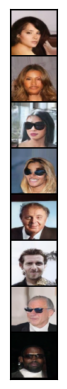

In [14]:
# set of possible classes the user can choose from
possible_classes = ['000', '001', '010', '011', '100', '101', '110', '111']

# --- Chose DDIM or DDPM ---
while True:
    try:
        approach = str(input('Use DDPM or DDIM? (enter: ddpm or ddim) '))

        if approach.lower() == 'ddim' or approach.lower() == 'ddpm':
            break
        else:
            print("Error: Enter ddpm or ddim. Please try again.")

    except ValueError:
        print("Error: Invalid input. Please enter a string.")

# --- Chose lambda value for guidance ---
while True:
    try:
        cfg_lambda = int(input('Choose a value for the guidance lambda (raccomended between -7 and 7): '))
        break

    except ValueError:
        print("Error: Invalid input. Please enter a whole number.")

# --- Get the number of rows ---
while True:
    try:
        number_of_row = int(input('How many rows of faces do you want to generate? (Min 1, Max 8): '))


        if 1 <= number_of_row <= 8:
            break
        else:
            print("Error: The number must be between 1 and 8.")

    except ValueError:
        print("Error: Invalid input. Please enter a whole number.")

# --- Get the number of samples per row with ---
while True:
    try:
        faces_per_row = int(input('How many samples per row? (Min 1, Max 10): '))

        if 1 <= faces_per_row <= 10:
            break
        else:
            print("Error: The number must be between 1 and 10. Please try again.")

    except ValueError:
        print("Error: Invalid input. Please enter a whole number.")

# --- Save name ---

save_name = str(input('Enter the name to save the generated picture (leave blank if you do not want to save): '))



# --- Get the class for each row and populate the dictionary ---
classes = {}

if number_of_row==8:
    for i in range(number_of_row):
        classes[i] = [int(digit) for digit in possible_classes[i]]
else:
    for i in range(number_of_row):
        while True:
            row_class = input(f'Which class should be in row {i+1}?\nPossible choices: {possible_classes}\n> ')

            if row_class in possible_classes:
                class_vector = [int(digit) for digit in row_class]

                classes[i] = class_vector

                break
            else:
                print(f"Error: '{row_class}' is not a valid choice. Please select from the list.")

print("\n--- Generation Parameters Set ---")
print(f"Number of rows: {number_of_row}")
print(f"Faces per row: {faces_per_row}")
print(f"Generating with: {approach}")
print(f"classifier free guidance lambda: {cfg_lambda}")
print("Class configuration [GENDER, EYEGLASSES, BEARD]:")
for row, class_vector in classes.items():
    print(f"  Row {row+1}: {class_vector} ")

func = generate_sample
if approach == 'ddim':
    func = generate_sample_ddim

generate_grid(fun=func,den_net=den_net, time_encoder=time_encoder, noise_size=(faces_per_row * number_of_row, 3, 64, 64), classes=classes , samples_per_row=faces_per_row, name=save_name, cfg_lambda=cfg_lambda)

In [ ]:
#!pip install --upgrade sympy